In [60]:
#default_exp dcae

In [61]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# DCAE: Deep Convolutional Autoencoder

> This notebook tries to apply the ideas of the paper [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y),
with regard to the application of DCAEs for compressing multivariate time series data.

In [62]:
#export
from fastcore import test
from tsai.all import *

In [63]:
#hide
from torch.utils.data import TensorDataset
from timecluster_hub.all import *
import wandb
from yaml import load, FullLoader
from fastcore.all import *
from datetime import datetime
import pickle
from fastai.callback.wandb import WandbCallback

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

## Notebook configuration

In [64]:
config = AttrDict(
    use_wandb = True, # Whether to use or not wandb for experiment tracking
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = 'vrodriguezf90',
    wandb_project = 'tchub',
    artifact_train_name_version = 'taxi:v2',
    artifact_validation_name_version = 'taxi:v3',
    w = 48, # window size for the sliding window
    stride = 24, # n datapoints the window is moved ahead along the sequence in the sliding window
    t = 0, # determines the step where the first window is applied
    delta = 48, # Size of the autoencoder bottleneck layer (for now use the same as w)
    nfs = [64,32,12],
    kss = [10,5,5],
    output_filter_size = 10,
    pool_szs = [2, 2, 3],
    batch_size = 256,
    epochs = 50,
    top_k = 3 # Number of elements to analyse for the top losses
)

In [65]:
#hide
run_dcae = wandb.init(entity = config.wandb_entity,
                      # work-nbs is a place to log draft runs
                      project=config.wandb_project if config.use_wandb else 'work-nbs',
                      group=config.wandb_group,
                      job_type='encoder_DCAE',
                      allow_val_change=True,
                      mode='online', # Need to be always online to download artifacts
                      config=config,
                      # When use_wandb is false the run is not linked to a personal account
                      #NOTE: This is not working right now
                      anonymous = 'never' if config.use_wandb else 'must',
                      resume=False)
config = run_dcae.config  # Object for storing hyperparameters

## Loading the datasets

To load the dataset we will download a specific dataset artifact from the collection of artifacts
stored in the weights and biases (wandb) project associated to this experiment.

In [66]:
ds_train_artifact = run_dcae.use_artifact(f'{config.wandb_project}/{config.artifact_train_name_version}')
ds_validation_artifact = run_dcae.use_artifact(f'{config.wandb_project}/{config.artifact_validation_name_version}')

The artifact must have been logged from a `TSArtifact` object. If that's true, the metadata of the downloaded artifact will contain all the necessary information to recover the dataframe containing the time series.

In [67]:
ds_train_artifact.metadata

{'TS': {'ed': '2014-12-14 23:30:00',
  'sd': '2014-10-01 00:00:00',
  'freq': '<30 * Minutes>',
  'hash': '-5374861116363264537',
  'vars': ['value'],
  'n_vars': 1,
  'created': 'from-df',
  'n_samples': 3600,
  'normalization': {'stds': {'value': 7084.011043358856},
   'means': {'value': 15836.711944444443}},
  'has_missing_values': 'False',
  'handle_missing_values_technique': 'linear_interpolation'}}

In [68]:
ds_validation_artifact.metadata

{'TS': {'ed': '2014-12-14 23:30:00',
  'sd': '2014-10-01 00:00:00',
  'freq': '<30 * Minutes>',
  'hash': '751119127652302362',
  'vars': ['value'],
  'n_vars': 1,
  'created': 'from-df',
  'n_samples': 3600,
  'has_missing_values': 'False',
  'handle_missing_values_technique': 'linear_interpolation'}}

The training data that will be used in the rest of the notebook will be stored in the dataframe `df_train`

In [69]:
df_train = ds_train_artifact.to_df()
df_train.head()

,value
timestamp,
2014-10-01 00:00:00,-0.435588
2014-10-01 00:30:00,-0.997981
2014-10-01 01:00:00,-1.246711
2014-10-01 01:30:00,-1.493464
2014-10-01 02:00:00,-1.644226


Validation data is not normalized. We need to normalize them with the means/stds of the training data

In [70]:
df_val = normalize_artifact(ds_validation_artifact, ds_train_artifact)
df_val.head()

Artifacts are compatible.


,value
timestamp,
2014-10-01 00:00:00,-0.435588
2014-10-01 00:30:00,-0.997981
2014-10-01 01:00:00,-1.246711
2014-10-01 01:30:00,-1.493464
2014-10-01 02:00:00,-1.644226


## Train

### Sliding window features

Define a continuous multivariate time-series data $D$ of dimension $d$ with $n$ time-steps, $D = X_1,X_2,\dots,X_n$ , where each $X_i = \{x_i^1,\dots,x_i^d\}$ . Let $w$ be the window width, $s$ the stride, and $t$ the start time of a sliding window in the data.

Define a new matrix $Z_k$ where each row is a vector of size $w$ of data extracted from the $k^{th}$ dimension.

\begin{aligned}&Z_k(w,s,t)\\&\quad =\begin{bmatrix} x_{t}^k&\quad x_{t+1}^k&\quad \dots&\quad x_{t+w-1}^k \\ x_{t+s}^k&\quad x_{t+s+1}^k&\quad \dots&\quad x_{t+s+w-1}^k \\ \vdots&\quad \vdots&\quad \ddots&\quad \vdots \\ x_{t+(r-1)s}^k&\quad x_{t+(r-1)s+1}^k&\quad \dots&\quad x_{t+(r-1)s+w-1}^k \end{bmatrix} \end{aligned}

where $r$ is the number of desired rows, and $t+(r-1)s+w-1 \le n$


$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [71]:
#test_eq(config.w % 12, 0)

The sliced data must be converted to a numpy array with shape $(n \times w \times d)$, where $n$ is the length of the time series, $w$ is the window size and $d$ is the number of dimensions in the time series. 

In [72]:
%%time
# TODO: move to data_format=channels first!
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
input_data, _ = sw(df_train)
validation_data, _ = sw(df_val)
print(f'input_data shape: {input_data.shape}')
print(f'validation_data shape: {validation_data.shape}')

input_data shape: (149, 1, 48)
validation_data shape: (149, 1, 48)
CPU times: user 1.4 ms, sys: 50 µs, total: 1.45 ms
Wall time: 1.28 ms


Test the number of slices and the size of each slice in the input_data

## Extract important features from the multivariate time series data through Deep Convolutional Autoencoders


Deep Convolutional Auto Encoders (DCAE) is a powerful method for learning high-level and mid-level abstractions from low-level raw data. It has the ability to extract features from complex and large time-series in an unsupervised manner. This is useful to overcome the complexity of multivariate time-series.

Compared to the conventional auto-encoder, DCAE has fewer parameters than the conventional auto-encoder which means less training time. Also, DCAE uses local information to reconstruct the signal while conventional auto-encoders utilize fully connected layers to globally do the reconstruction. DCAE is an unsupervised model for representation learning which maps inputs into a new representation space. It has two main parts which are the encoding part that is used to project the data into a set of feature spaces and the decoding part that reconstructs the original data. The latent space representation is the space where the data lie in the bottleneck layers.

The loss function of the DCAE is defined as the error between the input and the output. DCAE aims to find a code for each input by minimizing the mean squared error (MSE) between its input (original data) and output (reconstructed data). The MSE is used which assists to minimize the loss; thus, the network is forced to learn a low-dimensional representation of the input.

We will implement the DCAE of the paper [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y), whose architecture is shown in the table below:

![](https://i.imgur.com/3EjuAfQ.png)

Note that, in the paper, the input shape is $60 \times 3$, due to multivariate time series has 3 variables and the window size is 60. Generally, the size of the input/output of the autoencoder will depend on the shape of each slice obtained in the previos step. The number of latent features to be discovered is $60$ in the table above, but we can consider this as a free hyperparameter $\delta$. Also, according to the paper: "*The number of feature maps, size of filter and depth of the model are set based on the reconstruction error on validation set.*". Thus, we must provide flexibility in the creation of the DCAE in terms of these hyperparameters.º

In case you are not using a config file, you can also uncomment the following cell and define the hyperparameters in the fly

In [73]:
#hide
all_equal([len(x) for x in [config.nfs, config.kss, config.pool_szs]], 
          np.repeat(len(config.nfs), 3))

True

### Create the model

The implementation of the DCAE is done using Keras.

In [74]:
#export 
class DCAE_torch(Module):
    def __init__(self, c_in, seq_len, delta, nfs=[64, 32, 12], kss=[10, 5, 5], 
                 pool_szs=[2,2,3], output_fsz=10):
        """
        Create a Deep Convolutional Autoencoder for multivariate time series of `d` dimensions,
        sliced with a window size of `w`. The parameter `delta` sets the number of latent features that will be
        contained in the Dense layer of the network. The the number of features
        maps (filters), the filter size and the pool size can also be adjusted."
        """
        assert all_equal([len(x) for x in [nfs, kss, pool_szs]], np.repeat(len(nfs), 3)), \
            'nfs, kss, and pool_szs must have the same length'
        assert np.prod(pool_szs) == nfs[-1], \
            'The number of filters in the last conv layer must be equal to the product of pool sizes'
        assert seq_len % np.prod(pool_szs) == 0, \
            'The product of pool sizes must be a divisor of the window size'
        layers = []
        for i in range_of(kss):
            layers += [Conv1d(ni=nfs[i-1] if i>0 else c_in, nf=nfs[i], ks=kss[i]),
                       nn.MaxPool1d(kernel_size=pool_szs[i])]
        self.downsample = nn.Sequential(*layers)
        self.bottleneck = nn.Sequential(OrderedDict([
            ('flatten', nn.Flatten()),
            ('latent_in', nn.Linear(seq_len, delta)), 
            ('latent_out', nn.Linear(delta, seq_len)),
            ('reshape', Reshape(nfs[-1], seq_len // np.prod(pool_szs)))
        ]))
        layers = []
        for i in reversed(range_of(kss)):
            layers += [Conv1d(ni=nfs[i+1] if i != (len(nfs)-1) else nfs[-1], 
                              nf=nfs[i], ks=kss[i]),
                       nn.Upsample(scale_factor=pool_szs[i])]
        layers += [Conv1d(ni=nfs[0], nf=c_in, kernel_size=output_fsz)]
        self.upsample = nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.downsample(x)
        x = self.bottleneck(x)
        x = self.upsample(x)
        return x

In [75]:
m = DCAE_torch(c_in=input_data.shape[1], seq_len=config.w, delta=config.delta, 
               pool_szs=config.pool_szs, nfs=config.nfs)
print(m)
foo = torch.rand(1, input_data.shape[1], config.w)
foo.shape, m(foo).shape

DCAE_torch(
  (downsample): Sequential(
    (0): Conv1dSame(
      (conv1d_same): Conv1d(1, 64, kernel_size=(10,), stride=(1,))
    )
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 12, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (latent_in): Linear(in_features=48, out_features=48, bias=True)
    (latent_out): Linear(in_features=48, out_features=48, bias=True)
    (reshape): Reshape(bs, 12, 4)
  )
  (upsample): Sequential(
    (0): Conv1d(12, 12, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Upsample(scale_factor=3.0, mode=nearest)
    (2): Conv1d(12, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (3)

(torch.Size([1, 1, 48]), torch.Size([1, 1, 48]))

Train the model with fastai Learner class, to abstract from Pytorch's training loop

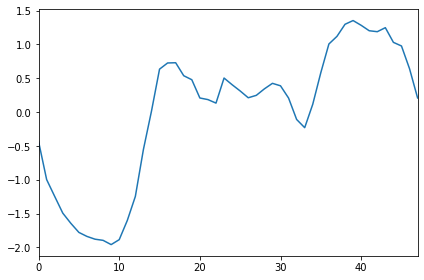

In [76]:
# TODO: Transform the y into a TSTensor
X, y, splits = combine_split_data([input_data, validation_data], [input_data, validation_data])
tfms = [None, [TSTensorBlock]]
dsets = TSDatasets(X, y, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, 
                               bs=[config.batch_size, config.batch_size*2])
dls.show_at(0)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,time
0,0.999698,0.998493,00:00
1,0.999089,0.996867,00:00
2,0.998333,0.994066,00:00
3,0.997233,0.989340,00:00
4,0.995590,0.981485,00:00
5,0.993119,0.967701,00:00
6,0.989264,0.941887,00:00
7,0.982915,0.891392,00:00
8,0.971904,0.791552,00:00
9,0.952186,0.612404,00:00


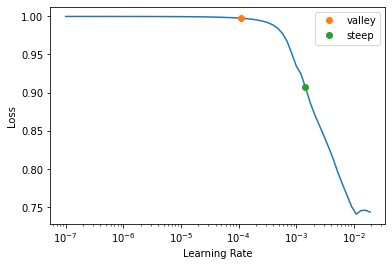

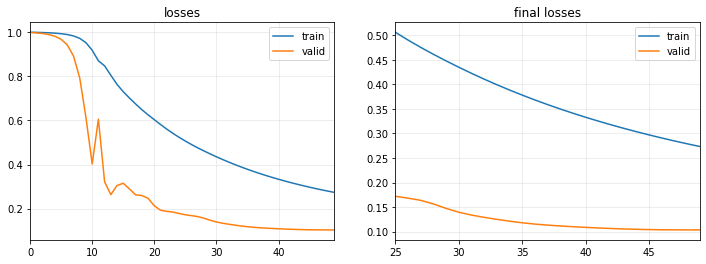

In [77]:
m = DCAE_torch(c_in=input_data.shape[1], seq_len=config.w, delta=config.delta, 
               pool_szs=config.pool_szs, nfs=config.nfs)
learn = Learner(dls=dls, model=m, loss_func=nn.MSELoss(), opt_func=Adam, 
                cbs=[WandbCallback(log_preds=False)])
lr_valley, lr_steep = learn.lr_find(suggest_funcs=[valley, steep])
learn.fit_one_cycle(config.epochs, lr_max=lr_steep)
learn.plot_metrics()




To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

Finally, log the learner to be used by the next notebook in the pipeline

In [78]:
#TODO: This logs everything, we only need the model...
run_dcae.log_artifact(ReferenceArtifact(learn, f'run-{run_dcae.id}-learner-dcae'))

## Baseline models

Calculate baseline models taking into account that the best prediction is the average and median value of each of the windows

Baseline predictions:

In [79]:
y_pred_baseline_med = tensor(baseline_model_predictor(validation_data, "median"))
y_pred_baseline_mean = tensor(baseline_model_predictor(validation_data, "mean"))

MSE calculation for each window

In [80]:
baseline_score_mean = F.mse_loss(y_pred_baseline_mean, tensor(validation_data))
baseline_score_median = F.mse_loss(y_pred_baseline_med, tensor(validation_data))
baseline_score_mean, baseline_score_median

(tensor(0.), tensor(0.))

Log values to Weight & Biases

In [81]:
run_dcae.log({
    'mse_baseline_median': baseline_score_median,
    'mse_baseline_mean': baseline_score_mean,
})

## Validate the autoencoder

Let's validate the autoencoder quality visually:

#### Get the best and the worst k predictions using the autoencoder

In [82]:
interp = Interpretation.from_learner(learn)

In [83]:
top_losses = interp.top_losses(3)
top_losses

torch.return_types.topk(
values=tensor([0.5685, 0.3439, 0.3156]),
indices=tensor([ 64, 106,  63]))

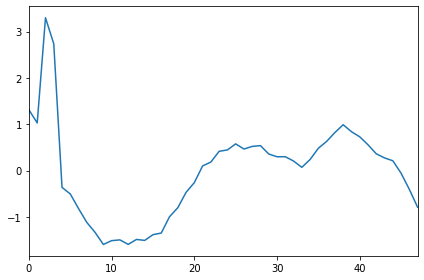

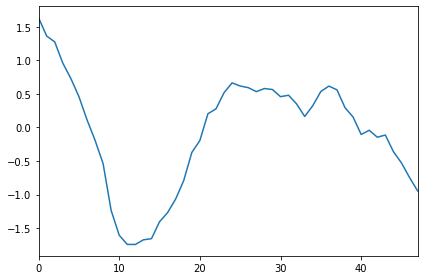

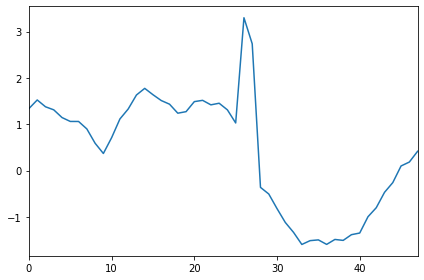

In [84]:
for i in top_losses.indices: dls.valid.show_at(i) 

In [85]:
run_dcae.finish()

epoch,50
eps_0,1e-05
lr_0,0.0
mom_0,0.94982
mse_baseline_mean,0.0
mse_baseline_median,0.0
raw_loss,0.1035
sqr_mom_0,0.99
train_loss,0.27353
valid_loss,0.10348
wd_0,0.01


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▂▄▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
mom_0,███▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇████
mse_baseline_mean,▁
mse_baseline_median,▁
raw_loss,███████▇▅▃▅▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,████████▇▇▇▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
valid_loss,██████▇▆▃▅▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
